#### This notebook goes through the steps of doing an overlay of NDVI (Normalized Difference Vegetation Index) in conjuction with pulling records from GBIF

#### Step One: Import the Necessary Libraries and Initialize the Google Earth Engine API

In [4]:
import ee

ee.Authenticate()

ee.Initialize(project='ee-krle4401')



In [5]:
from pygbif import occurrences as gbif_occ
import geopandas as gpd
import folium
from shapely.geometry import Point


##### Step 2: Fetch Some LandSat Imagery

In [8]:
# Define NDVI calculation
landsat = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterBounds(roi) \
    .filterDate('2020-01-01', '2020-12-31') \
    .map(lambda img: img.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI'))  # Corrected band names

# Get median NDVI for the specified time period
median_ndvi = landsat.median().clip(roi)


#### Step 3: Fetch vegetation observations from GBIF

In [11]:
# Fetch GBIF occurrences for vegetation within the ROI
geometry = "POLYGON((-123.5 37.0, -121.5 37.0, -121.5 38.0, -123.5 38.0, -123.5 37.0))"  # Example geometry
taxon_key = 6  # Plants (example taxon key)
occurrences = gbif_occ.search(
    taxonKey=taxon_key,
    hasCoordinate=True,
    geometry=geometry,
    year=2020,  # Example year
    limit=100
)

# Convert GBIF data to a GeoDataFrame
records = [
    {
        "species": occ.get("species", "Unknown"),
        "latitude": occ["decimalLatitude"],
        "longitude": occ["decimalLongitude"]
    }
    for occ in occurrences["results"]
]

# Create GeoDataFrame with geometry
gdf = gpd.GeoDataFrame(records, geometry=[Point(xy) for xy in zip(
    [r["longitude"] for r in records],
    [r["latitude"] for r in records]
)])
print(gdf.head())  # Confirm `gdf` contains data


                 species   latitude   longitude                     geometry
0          Pinus radiata  37.820328 -122.529858  POINT (-122.52986 37.82033)
1        Ribes malvaceum  37.903738 -121.928182  POINT (-121.92818 37.90374)
2  Arctostaphylos glauca  37.920340 -121.941526  POINT (-121.94153 37.92034)
3       Hedwigia ciliata  37.953533 -121.868172  POINT (-121.86817 37.95353)
4  Polytrichum piliferum  37.953525 -121.868080  POINT (-121.86808 37.95352)
100


#### Step 4: Overlay GBIF Vegetation on the NDVI layer

In [12]:
# Convert GeoDataFrame points to a GEE FeatureCollection
gbif_points = ee.FeatureCollection([
    ee.Feature(ee.Geometry.Point(row.geometry.x, row.geometry.y))
    for _, row in gdf.iterrows()
])


#### Step 5: Extract NDVI Values at GBIF Locations

In [13]:
# Sample NDVI values at GBIF points
samples = median_ndvi.sampleRegions(
    collection=gbif_points,
    scale=30  # 30m resolution of Landsat imagery
).getInfo()

# Extract NDVI values from the sampled data
ndvi_values = [feature['properties']['NDVI'] for feature in samples['features']]

# Add NDVI values to the GeoDataFrame
gdf['NDVI'] = ndvi_values
print(gdf)


                  species   latitude   longitude                     geometry  \
0           Pinus radiata  37.820328 -122.529858  POINT (-122.52986 37.82033)   
1         Ribes malvaceum  37.903738 -121.928182  POINT (-121.92818 37.90374)   
2   Arctostaphylos glauca  37.920340 -121.941526  POINT (-121.94153 37.92034)   
3        Hedwigia ciliata  37.953533 -121.868172  POINT (-121.86817 37.95353)   
4   Polytrichum piliferum  37.953525 -121.868080  POINT (-121.86808 37.95352)   
..                    ...        ...         ...                          ...   
95    Plocamium violaceum  37.044250 -122.234930  POINT (-122.23493 37.04425)   
96    Polyneura latissima  37.044250 -122.234930  POINT (-122.23493 37.04425)   
97                Unknown  37.044250 -122.234930  POINT (-122.23493 37.04425)   
98    Grateloupia angusta  37.044250 -122.234930  POINT (-122.23493 37.04425)   
99                Unknown  37.044250 -122.234930  POINT (-122.23493 37.04425)   

        NDVI  
0   0.149221

#### Step 6: Analyze and Visualize Results

In [14]:
# Import Folium for visualization
import folium

# Create a Folium map centered on the ROI
m = folium.Map(location=[37.5, -122.5], zoom_start=8)

# Add NDVI layer
ndvi_params = {'min': 0, 'max': 1, 'palette': ['blue', 'white', 'green']}
map_id = median_ndvi.getMapId(ndvi_params)
folium.TileLayer(
    tiles=map_id['tile_fetcher'].url_format,
    attr="Google Earth Engine",
    name="NDVI",
    overlay=True
).add_to(m)

# Add GBIF observation points
for _, row in gdf.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=f"{row['species']} - NDVI: {row['NDVI']:.2f}",
        icon=folium.Icon(color="green")
    ).add_to(m)

# Display the map
m


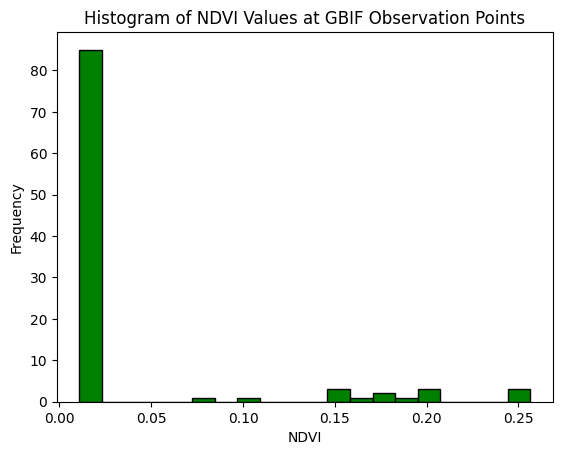

In [15]:
import matplotlib.pyplot as plt

# Plot histogram of NDVI values
plt.hist(gdf['NDVI'], bins=20, color='green', edgecolor='black')
plt.title("Histogram of NDVI Values at GBIF Observation Points")
plt.xlabel("NDVI")
plt.ylabel("Frequency")
plt.show()


In [16]:
# Summarize NDVI values
print("Summary Statistics for NDVI:")
print(gdf['NDVI'].describe())


Summary Statistics for NDVI:
count    100.000000
mean       0.036271
std        0.063426
min        0.010902
25%        0.010902
50%        0.010902
75%        0.010902
max        0.256511
Name: NDVI, dtype: float64
